In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import functions
import glob as glob

In [3]:
fbkdir = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/feedbacks/'
tempdir = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/feedback_input/'

In [4]:
cldtype = 'ALL'
experiments = ['abrupt-0_5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2']
ds_list = []
dT_list = []
dT_annavg_list = []

interval=15
if interval == 15:
    tslicelist = [slice('1920-01-01', '1934-12-31'), slice('1935-01-01', '1949-12-31'),
                slice('1950-01-01', '1964-12-31'), slice('1965-01-01', '1979-12-31'),
                slice('1980-01-01', '1994-12-31'), slice('1995-01-01', '2009-12-31'),
                slice('2010-01-01', '2024-12-31'), slice('2025-01-01', '2039-12-31'),
                slice('2040-01-01', '2054-12-31'), slice('2055-01-01', '2069-12-31')]
elif interval == 10:
    tslicelist = [slice('1920-01', '1929-12'), slice('1930-01-01', '1939-12-31'),
        slice('1940-01-01', '1949-12-31'), slice('1950-01-01', '1959-12-31'),
        slice('1960-01-01', '1969-12-31'), slice('1970-01-01', '1979-12-31'),
        slice('1980-01-01', '1989-12-31'), slice('1990-01-01', '1999-12-31'),
        slice('2000-01-01', '2009-12-31'), slice('2010-01-01', '2019-12-31'),
        slice('2020-01-01', '2029-12-31'), slice('2030-01-01', '2039-12-31'),
        slice('2040-01-01', '2049-12-31'), slice('2050-01-01', '2059-12-31'),
        slice('2060-01-01', '2069-12-31')]
N = int(150/interval)

pi_temp = xr.open_dataset(tempdir+'tas_piClim_final30years.nc')
pi_temp = pi_temp.groupby('time.month').mean('time')
pi_temp = pi_temp.rename({'month':'time'})
pi_temp_annavg = pi_temp.mean('time')

for exp in experiments:

    fbk_files = glob.glob(fbkdir+'interval'+str(interval)+'/'+cldtype+'_'+exp+'_*')
    fbk_files.sort()
    fbk_ds = xr.open_mfdataset(fbk_files, combine='nested', concat_dim='period')
    ds_list.append(fbk_ds)

    temp_ds = xr.open_dataset(tempdir+'tas_'+exp+'_1920-01-01_2069-12-31.nc')

    temp_annavg = temp_ds.groupby('time.year').mean('time')
    temp_annavg['tas'] = temp_annavg['tas'] - pi_temp_annavg['tas']
    dT_annavg_list.append(temp_annavg)
    
    dT = []
    for tslice in tslicelist:
        temp_slice = temp_ds.sel(time=tslice)
        temp_slice = temp_slice.groupby('time.month').mean('time')
        temp_slice = temp_slice.rename({'month':'time'})
        temp_slice['tas'] = temp_slice['tas'] - pi_temp['tas']
        dT.append(temp_slice)

    dT = xr.concat(dT, dim='period')
    dT_list.append(dT)


ds = xr.concat(ds_list, dim='co2_conc')
ds = ds.assign_coords({'period':np.arange(N)*interval})
ds = ds.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})

ds_dT = xr.concat(dT_list, dim='co2_conc')
ds_dT = ds_dT.assign_coords({'period':np.arange(N)*interval})
ds_dT = ds_dT.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})

ds_dT_annavg = xr.concat(dT_annavg_list, dim='co2_conc')

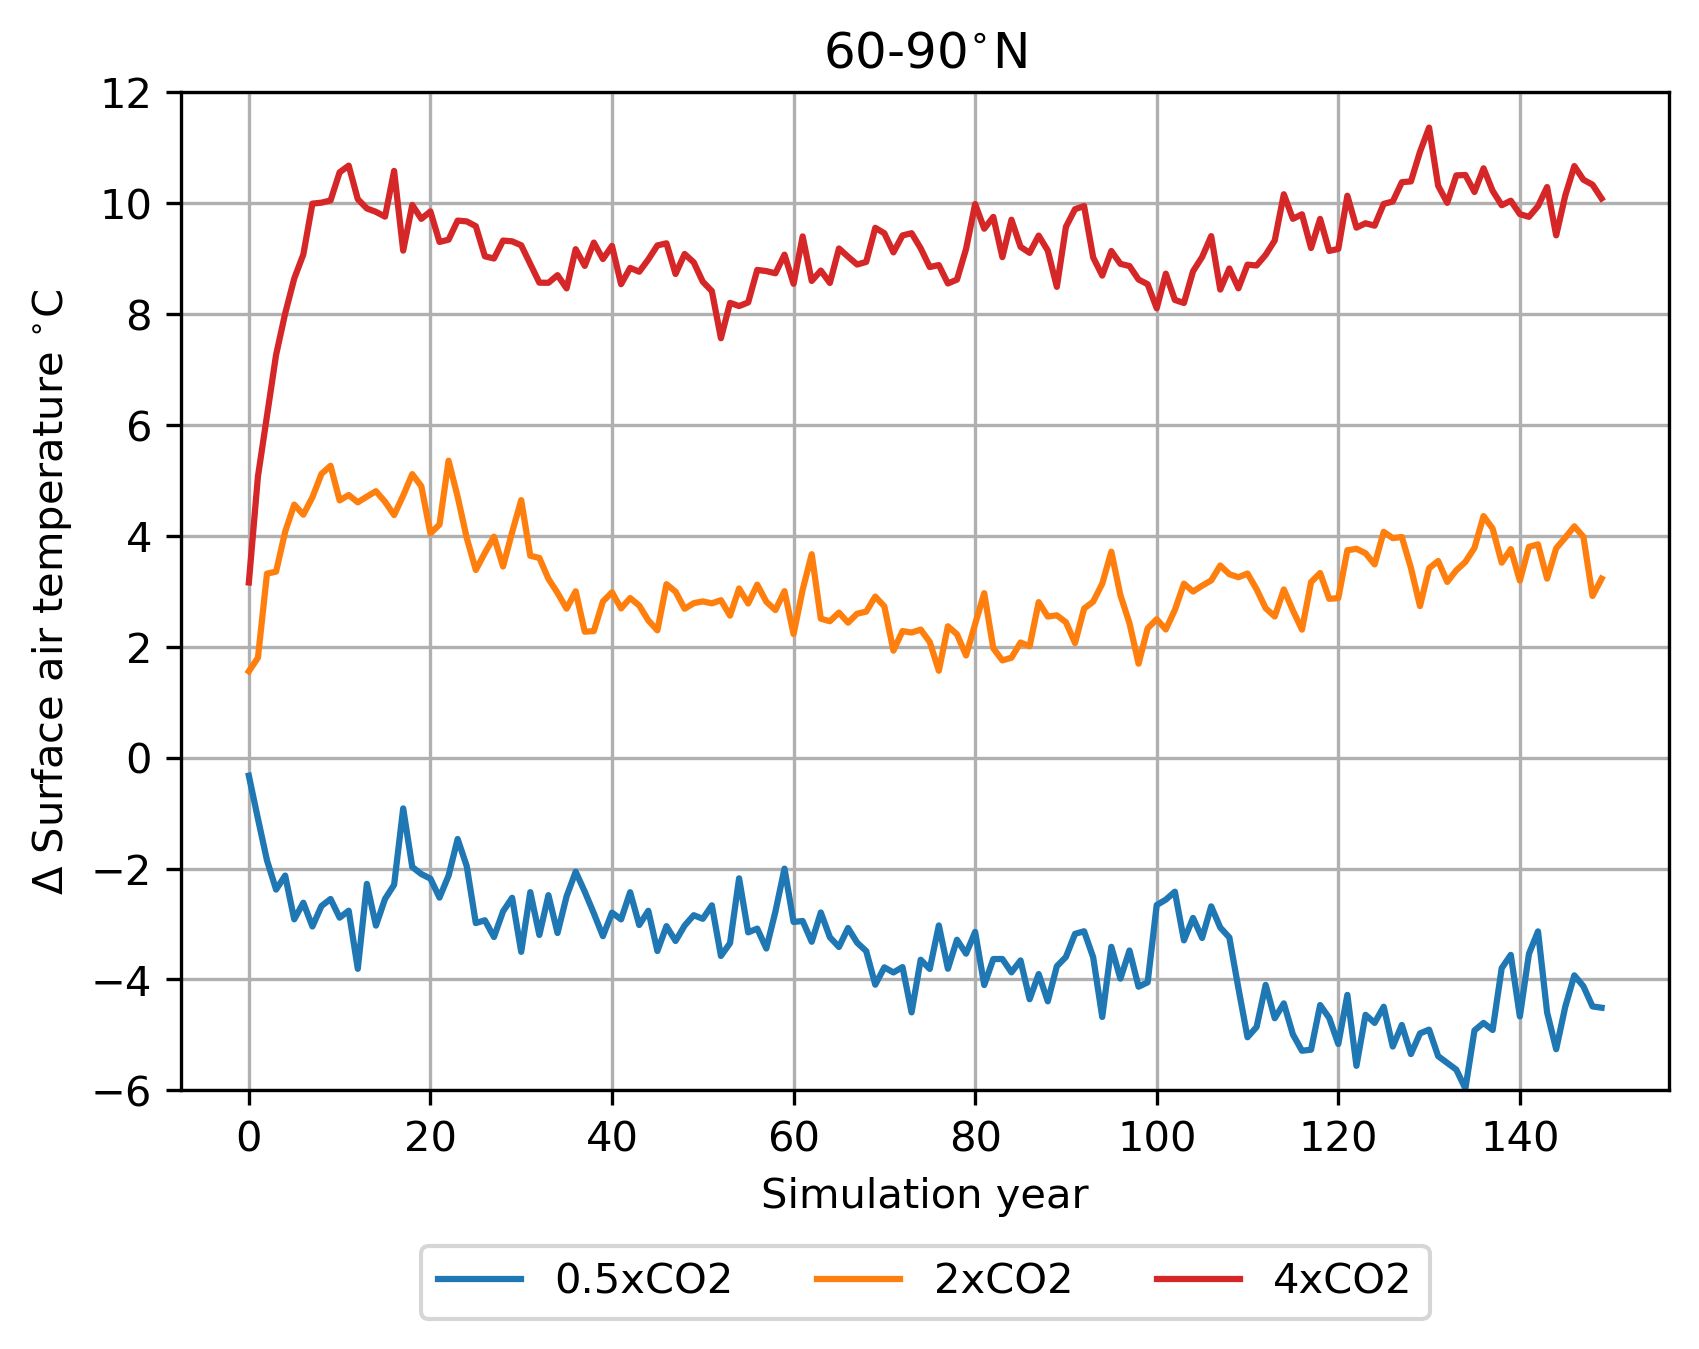

In [55]:
ds_temp_annavg = functions.computeWeightedMean(ds_dT_annavg.sel(lat=slice(60,90)))

plt.figure(dpi=300)
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=0), label='0.5xCO2', color='tab:blue')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=1), label='2xCO2', color='tab:orange')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=2), label='4xCO2', color='tab:red')
plt.xlabel('Simulation year')
plt.legend(loc='best')
plt.title('60-90$^{\circ}$N')
plt.ylabel('$\Delta$ Surface air temperature $^{\circ}$C')
plt.ylim([-6, 12])
plt.grid()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                box.width, box.height * 0.9])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

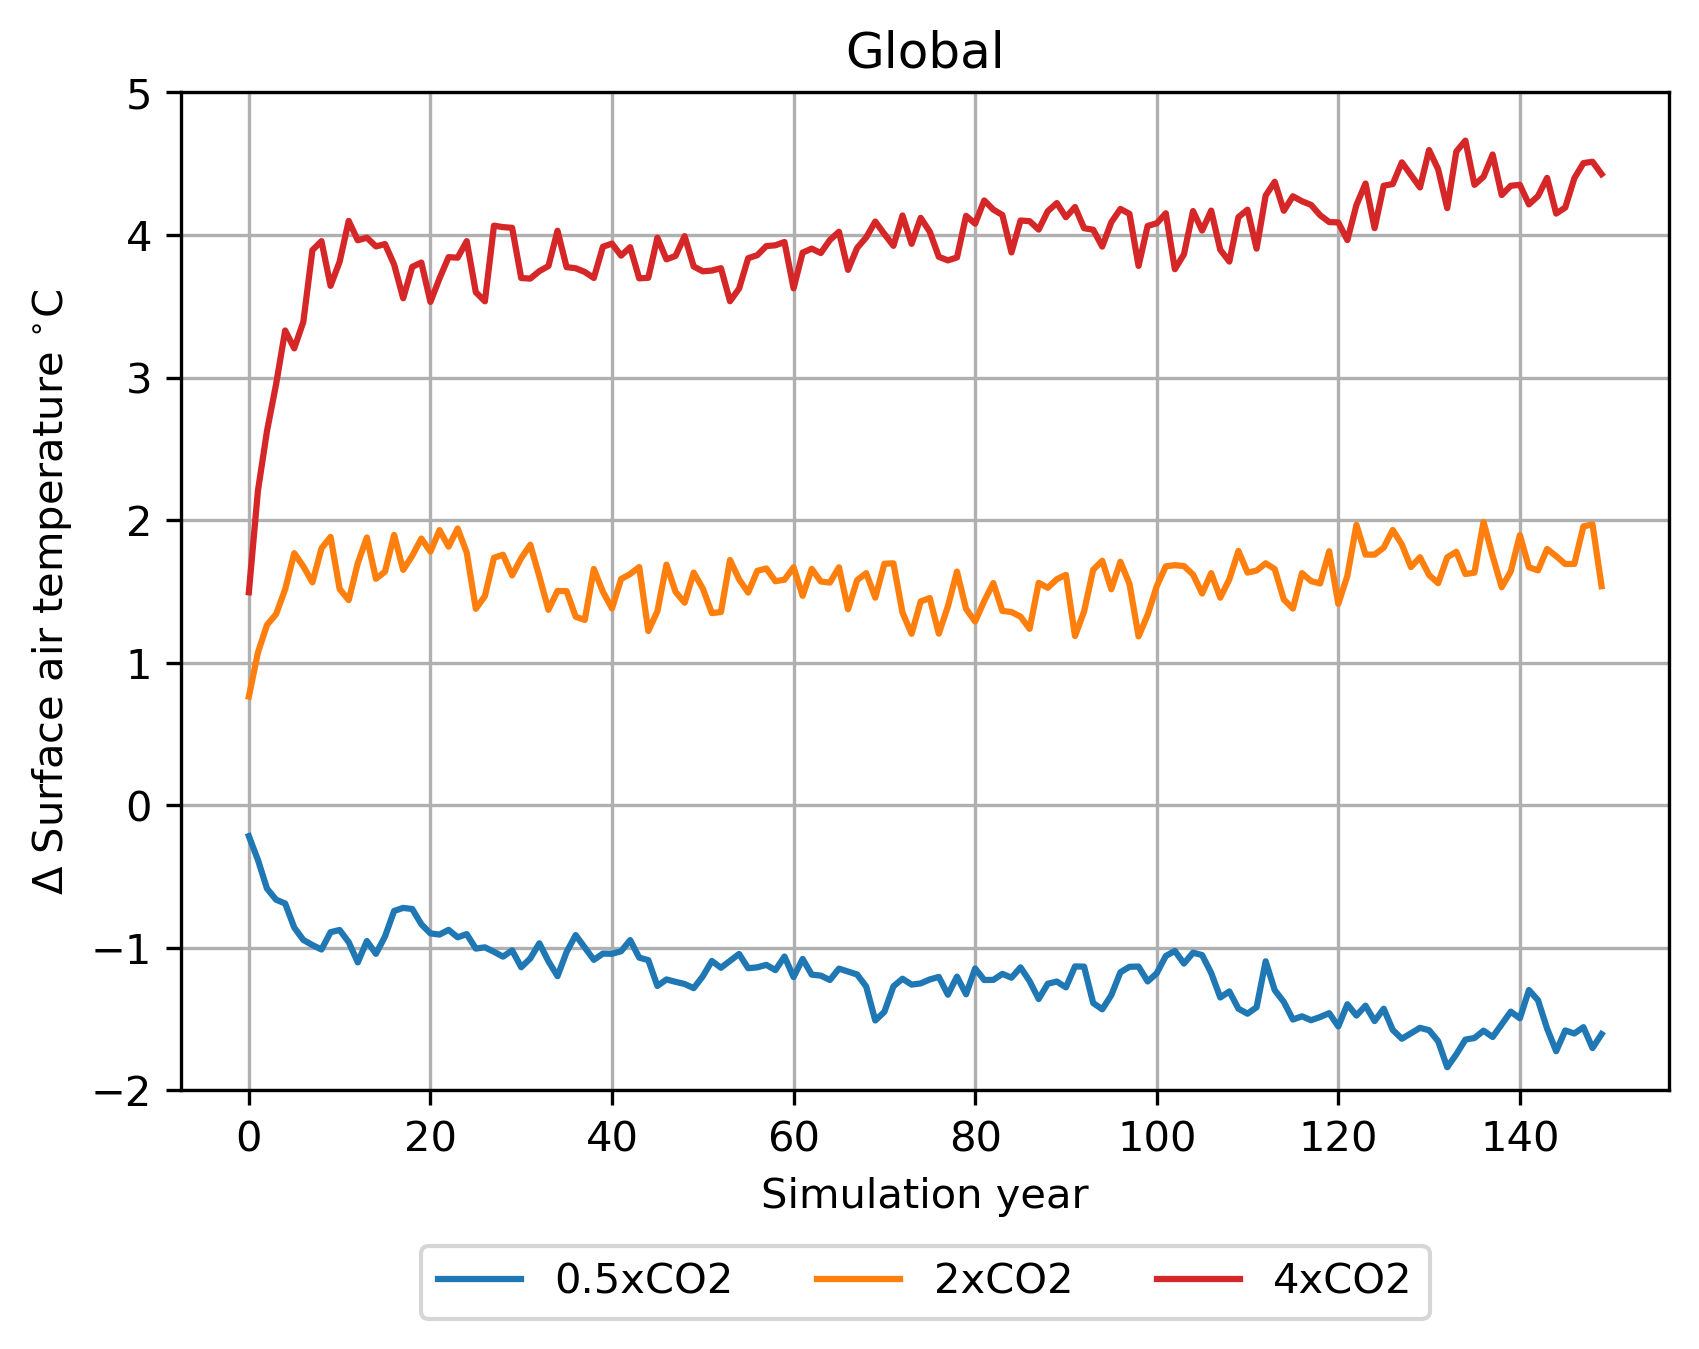

In [6]:
ds_temp_annavg = functions.computeWeightedMean(ds_dT_annavg.sel(lat=slice(-90,90)))

plt.figure(dpi=300)
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=0), label='0.5xCO2', color='tab:blue')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=1), label='2xCO2', color='tab:orange')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=2), label='4xCO2', color='tab:red')
plt.xlabel('Simulation year')
plt.legend(loc='best')
plt.title('Global')
plt.ylabel('$\Delta$ Surface air temperature $^{\circ}$C')
plt.ylim([-2, 5])
plt.grid()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                box.width, box.height * 0.9])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

### Plot cloud feedbacks as a function of time

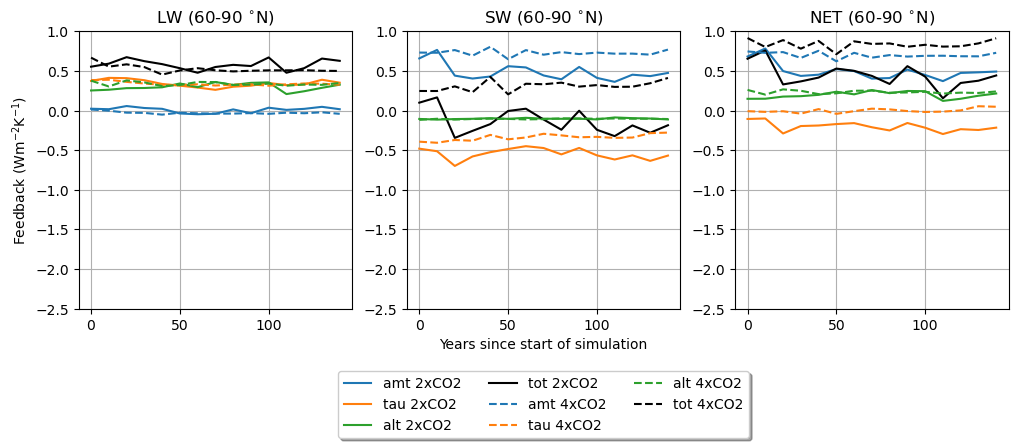

In [10]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt']
var_colors = ['tab:blue', 'tab:orange', 'tab:green']
exp_linestyles = ['-', '--', '-.']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90))).mean('time')

fig, axs = plt.subplots(1,3, figsize=(12, 4))
for i, co2_conc in enumerate(['2xCO2', '4xCO2']):
    for j in range(len(components)):
        comp = components[j]
        for var, color in zip(variables, var_colors):
            axs[j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc), color=color, label=var+' '+co2_conc, linestyle=exp_linestyles[i])
        axs[j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc), color='black', label='tot '+co2_conc, linestyle=exp_linestyles[i])

for i in range(len(axs)):
    axs[i].set_title(components[i]+' ('+str(Arctic_limit)+'-90 $^{\circ}$N)')
    axs[i].set_ylim([-2.5, 1])
    axs[i].grid()

    # Shrink bokx size to make room for legend
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

axs[0].set_ylabel('Feedback (Wm$^{-2}$K$^{-1}$)')
axs[1].set_xlabel('Years since start of simulation')
# Put a legend below middle axis
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)


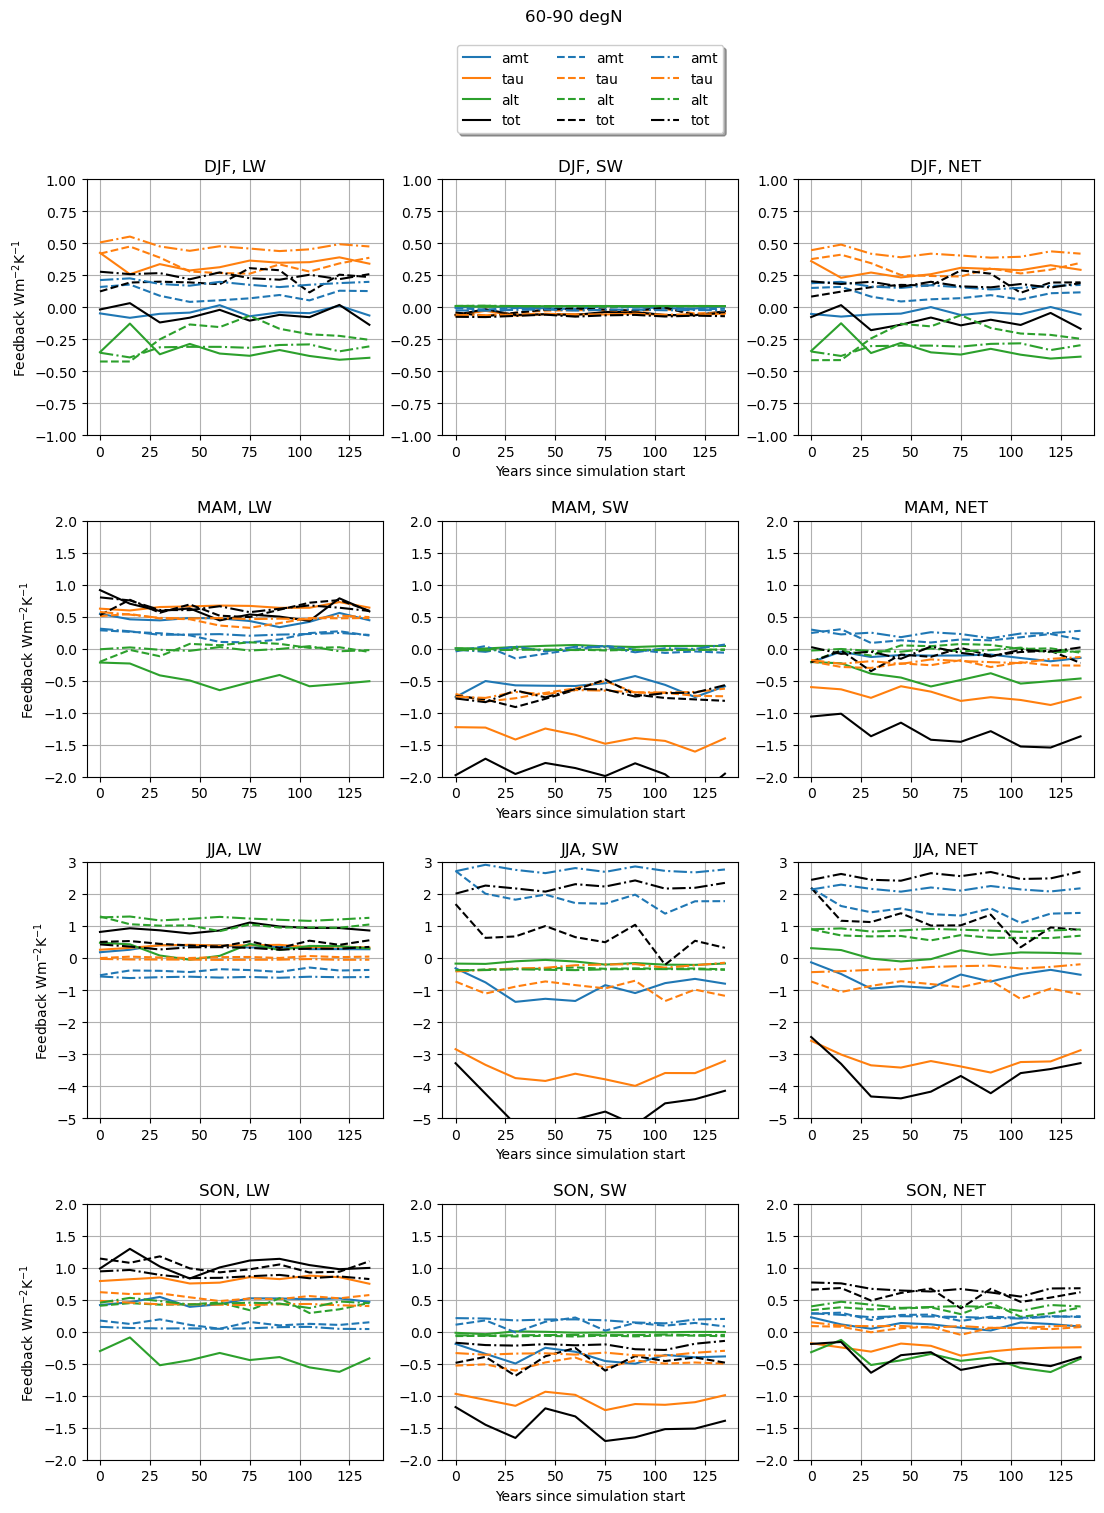

In [7]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:blue', 'tab:orange', 'tab:green',]
exp_linestyles = ['-', '--', '-.']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))

fig, axs = plt.subplots(4,3, figsize=(13, 17))
for k in range(len(seasons)):
    ds_dT_Arctic_s = functions.computeSeasonalMean(ds_dT_Arctic, season=seasons[k])
    for i in range(len(ds_Arctic.co2_conc.values)):
        co2_concs = ds_Arctic.co2_conc.values
        for j in range(len(components)):
            comp = components[j]
            for var, color in zip(variables, var_colors):
                axs[k, j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_concs[i], season=seasons[k]), color=color, label=var, linestyle=exp_linestyles[i])
            axs[k, j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_concs[i], season=seasons[k]), color='black', label='tot', linestyle=exp_linestyles[i])
fig.suptitle(str(Arctic_limit)+'-90 degN')

for k in range(len(seasons)):
    axs[k, 0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
    axs[k, 1].set_xlabel('Years since simulation start')
    
    for i in range(len(ds_Arctic.co2_conc)):
        axs[k, i].set_title(seasons[k]+', '+components[i])
        if k == 0:
            axs[k, i].set_ylim([-1, 1])
        elif k == 2:
            axs[k, i].set_ylim([-5, 3])
        else:
            axs[k, i].set_ylim([-2, 2])

        axs[k, i].grid()

        # Shrink box size to make room for legend
        box = axs[k, i].get_position()
        axs[k, i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])
    
# Put a legend below middle axis
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.55),
          fancybox=True, shadow=True, ncol=3)

### Plot feedbacks as a function of temperature

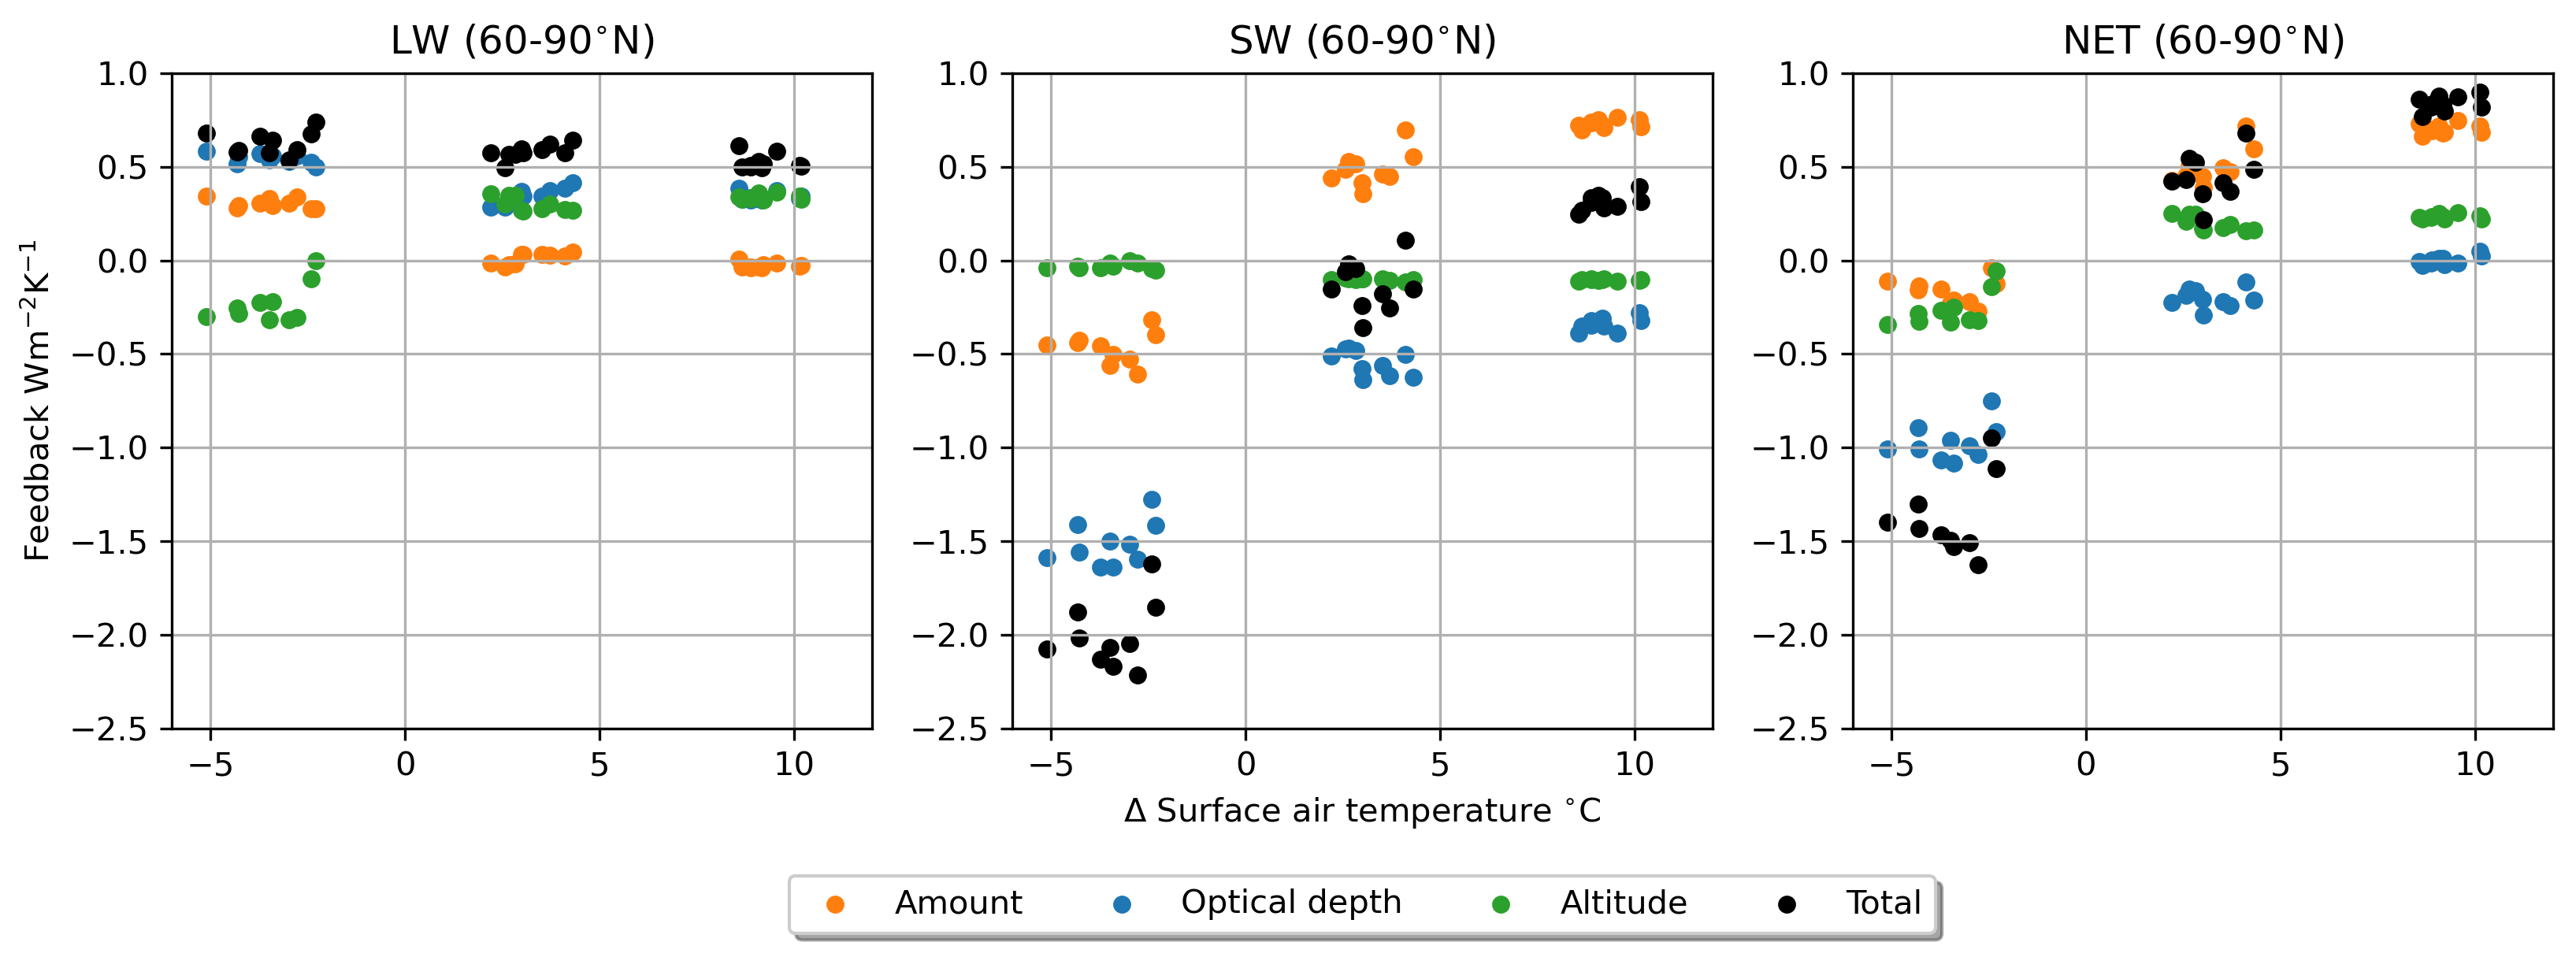

In [ ]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green',]
exp_linestyles = ['-', '--', '-.']

Arctic_limit = -90
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90))).mean('time')

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300)
for i in range(len(ds_Arctic.co2_conc)):
    for j in range(len(components)):
        comp = components[j]
        for var, color, label in zip(variables, var_colors, var_labels):
            if i == 0: # add label
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, label=label, linestyle='-', s=20)
            else:
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, linestyle='-', s=20)
        if i == 0: # add label
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', label='Total', linestyle='-', s=20)
        else:
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', linestyle='-', s=20)

for i in range(len(axs)):
    axs[i].set_title(components[i]+' ('+str(Arctic_limit)+'-90$^{\circ}$N)')
    axs[i].set_ylim([-2.5, 1])
    axs[i].set_xlim([-6, 12])
    axs[i].grid()

    # Shrink bokx size to make room for legend
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

axs[0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
axs[1].set_xlabel('$\Delta$ Surface air temperature $^{\circ}$C')
# Put a legend below middle axis
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


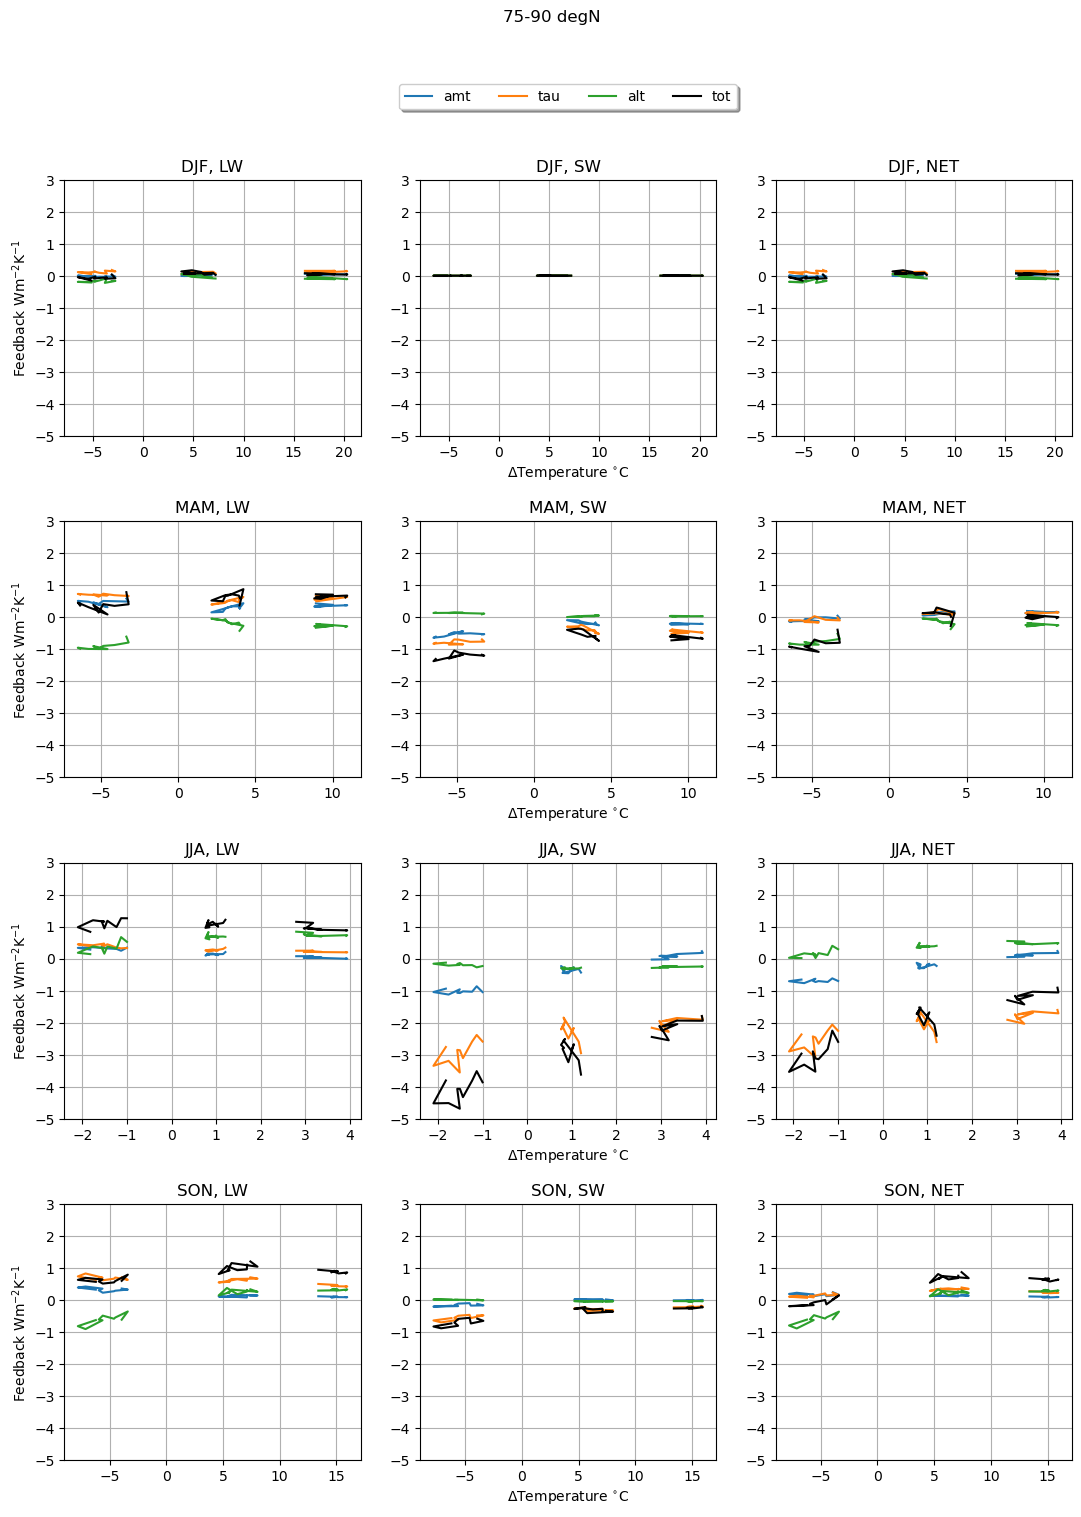

In [24]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:blue', 'tab:orange', 'tab:green',]
exp_linestyles = ['-', '--', '-.']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

Arctic_limit = 75
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))

fig, axs = plt.subplots(4,3, figsize=(13, 17))
for k in range(len(seasons)):
    ds_dT_Arctic_s = functions.computeSeasonalMean(ds_dT_Arctic, season=seasons[k])
    for co2_conc in ds_Arctic.co2_conc.values:
        for j in range(len(components)):
            comp = components[j]
            for var, color in zip(variables, var_colors):
                if co2_conc == '0.5xCO2' and k==0: # add label
                    axs[k, j].plot(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, label=var, linestyle='-')
                else:
                    axs[k, j].plot(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, linestyle='-')
            if co2_conc == '0.5xCO2' and k==0: # add label
                axs[k, j].plot(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', label='tot', linestyle='-')
            else:
                axs[k, j].plot(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', linestyle='-')

fig.suptitle(str(Arctic_limit)+'-90 degN')

for k in range(len(seasons)):
    axs[k, 0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
    axs[k, 1].set_xlabel('$\Delta$Temperature $^{\circ}$C')
    
    for i in range(len(ds_Arctic.co2_conc)):
        axs[k, i].set_title(seasons[k]+', '+components[i])
        axs[k, i].set_ylim([-5, 3])
        axs[k, i].grid()

        # Shrink box size to make room for legend
        box = axs[k, i].get_position()
        axs[k, i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])
    
# Put a legend below middle axis
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
          fancybox=True, shadow=True, ncol=5)

Text(0.5, 0, 'Wm$^{-2}$K$^{-1}$')

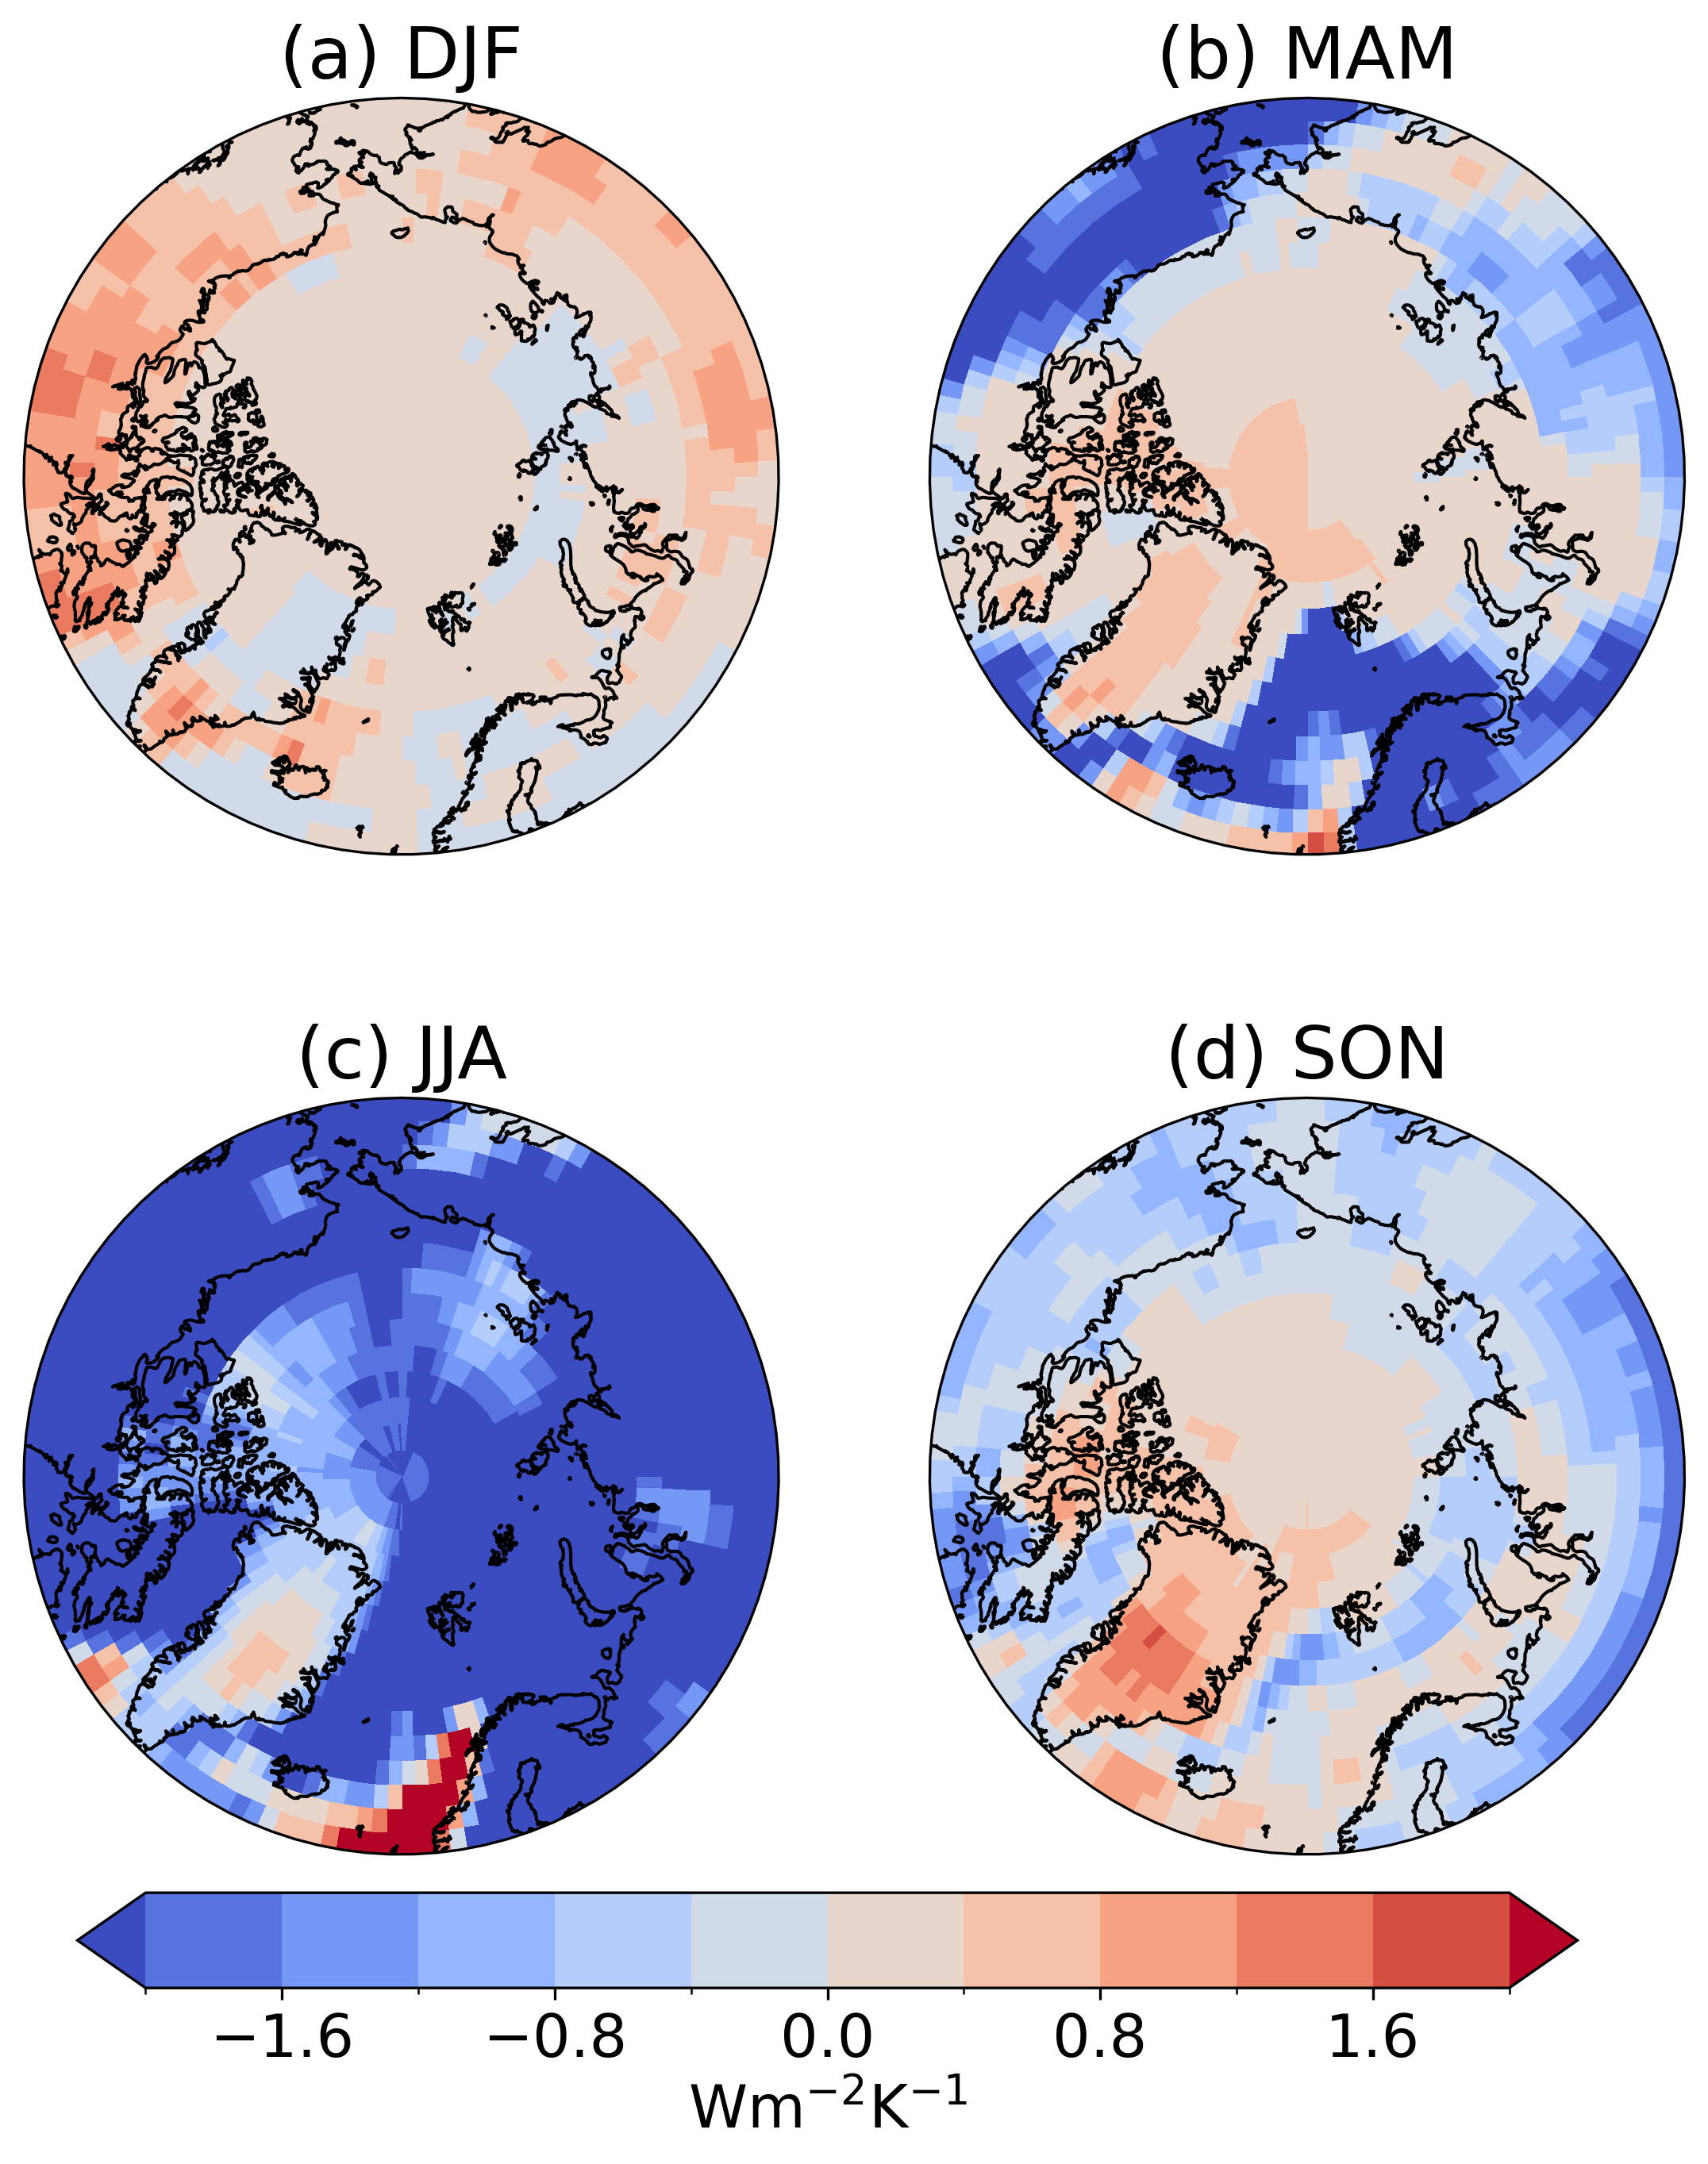

In [117]:
Arctic_limit = 60
ds_s = ds.groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))
var = 'NETcld_tau'
co2_conc = '0.5xCO2'
period=135
levels=np.linspace(-2, 2, 11)

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))
#plt.subplots_adjust(top=0.85)

for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
    
    functions.polarCentral_set_latlim([60,90], ax)
    data = ds_s[var].sel(season=season, period=period, co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    ax.set_title(label+" "+season, fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel("Wm$^{-2}$K$^{-1}$", fontsize=18)

#plt.savefig(wpath+"pdf/"+var+"_"+case1+"_"+case2+"eqbar.pdf", bbox_inches='tight')
#plt.savefig(wpath+"png/"+var+"_"+case1+"_"+case2+"eqbar.png", bbox_inches='tight')
#plt.savefig(wpath+"pdf/"+var+"_"+case1+"_"+case2+".pdf", bbox_inches='tight')
#plt.savefig(wpath+"png/"+var+"_"+case1+"_"+case2+".png", bbox_inches='tight')

#plt.clf()

Text(0.5, 0, 'Wm$^{-2}$K$^{-1}$')

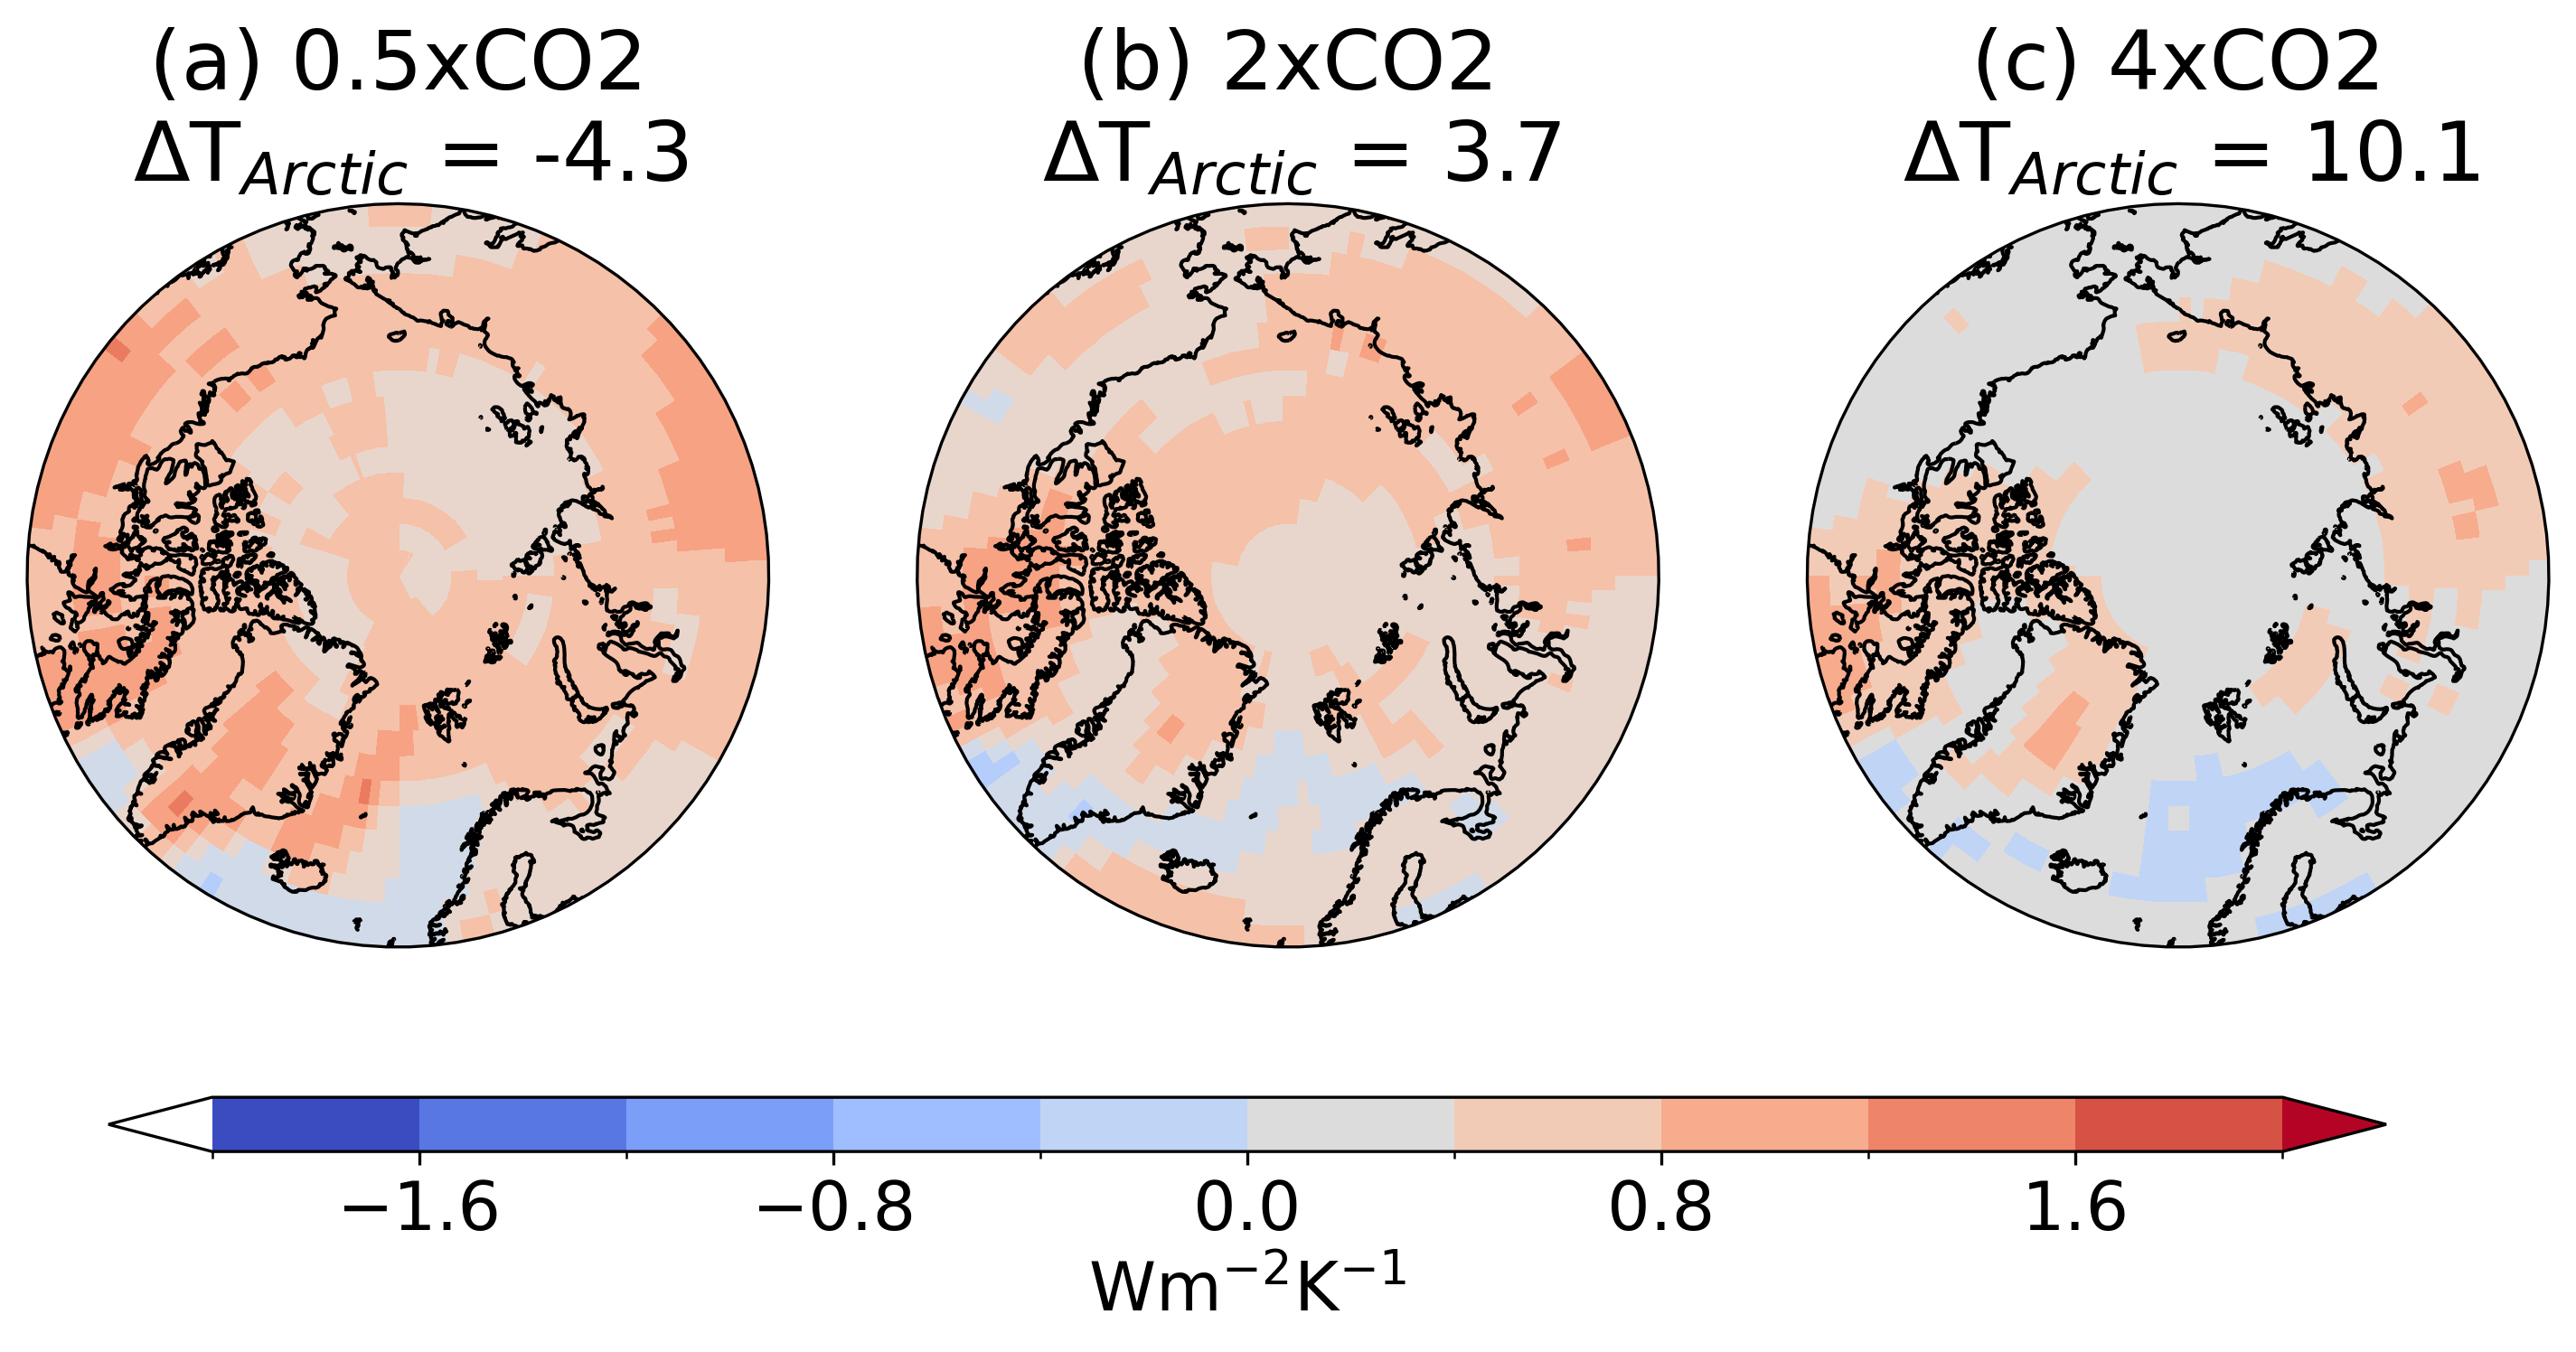

In [98]:
Arctic_limit = 60
ds_mean = ds.mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))
var = 'LWcld_tau'
period = 135
levels=np.linspace(-2, 2, 11)

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[12, 5],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 3, 1, projection=ccrs.Orthographic(0, 90))
ax2 = plt.subplot(1, 3, 2, projection=ccrs.Orthographic(0, 90))
ax3 = plt.subplot(1, 3, 3, projection=ccrs.Orthographic(0, 90))
#plt.subplots_adjust(top=0.85)

for ax,co2_conc,label in zip([ax1, ax2, ax3], ['0.5xCO2', '2xCO2', '4xCO2'], ["(a)", "(b)", "(c)"]):
    
    functions.polarCentral_set_latlim([60,90], ax)
    #data = ds_mean[var].sel(period=135, co2_conc=co2_conc) - ds_mean[var].sel(period=0, co2_conc=co2_conc)
    data = ds_mean[var].sel(period=period, co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    deltaT = np.round(ds_dT_Arctic['tas'].sel(period=period, co2_conc=co2_conc).mean('time').values, 1)
    ax.set_title(label+" "+co2_conc+'\n $\Delta$T$_{Arctic}$ = '+str(deltaT), fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel("Wm$^{-2}$K$^{-1}$", fontsize=18)